# Classification of Animals in 10 classes

# 1. Importing Libraries

In [1]:
# Deep Learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
import keras.callbacks as callbacks

# from tensorflow.keras.layers.experimental import preprocessing

# from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.vgg19 import VGG19
# from keras.applications.vgg19 import preprocess_input


# Data processing and visualization (+ utils)
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

## 2. Loading the dataset

Getting current working directory and dataset location

In [2]:
current_path = os.getcwd()
img_path = os.path.join(current_path, 'raw-img')

Importing the dataset and defining train and test sets

In [3]:
img_size = (224,224)
batch_size = 32
val_split = 0.2
seed = 21


train = tf.keras.utils.image_dataset_from_directory(
    img_path,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=val_split,
    subset='training',
    seed=seed
    )

val = tf.keras.utils.image_dataset_from_directory(
    img_path,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=val_split,
    subset='validation',
    seed=seed
    )

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


Getting labels names (for visualization)

In [4]:
label_names = train.class_names
print(label_names)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


Note that the labels are in italian and are traslated in english in the following code: <br>
"cane" = "dog", "cavallo" = "horse", "elefante" = "elephant", "farfalla" = "butterfly", "gallina" = "hen", \
"gatto" = "cat", "mucca" = "cow", "pecora" = "sheep", "ragno" = "spider", "scoiattolo" = "squirrel"

## 3. Data Preprocessing

Normalizing the data for performance and better results

In [5]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train = train.map(process)
val = val.map(process)

Sampling image in order to check if the data is processed correctly

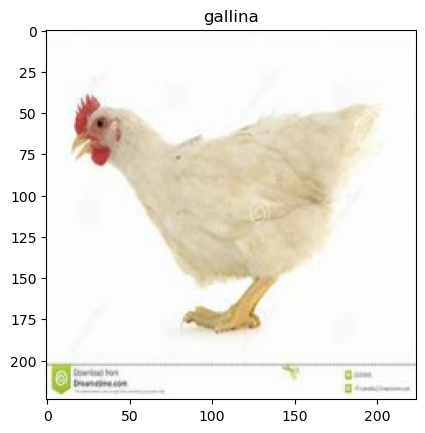

In [6]:
img_num = random.randint(0,32)
sample = train.take(1).map(lambda x, y: (x[0],y[0])).as_numpy_iterator()
for i,j in sample:
    plt.imshow(i)
    plt.title(label_names[j])
    plt.show()

## 4. Data Augmentation

Using data augmentation to increase the number of images in the dataset, in order to improve the performance and avoid overfitting

In [7]:
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     horizontal_flip=True,
#     brightness_range=[0.5, 1.5],
#     zoom_range=[0.8, 1.2],
# )

# data_augmentation = Sequential([
#     # Preprocessing
#     preprocessing.RandomFlip('horizontal'), # flip images horizontally
#     preprocessing.RandomContrast(0.2), # contrast change by up to 20%
#     preprocessing.RandomZoom(0.2), # zoom by up to 20%
#     preprocessing.RandomRotation(0.2), # rotate by up to 20%
# ], name='data_augmentation')

## 5. Building the model

First off let's define the model architecture

Then we compile the model

In [8]:
vgg19_model = Sequential(
    [
        # # Data Augmentation
        # data_augmentation,

        # Convolutional Layers
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        
        MaxPooling2D((2, 2), strides=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        
        MaxPooling2D((2, 2), strides=(2, 2)),
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        
        MaxPooling2D((2, 2), strides=(2, 2)),
        
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        
        MaxPooling2D((2, 2), strides=(2, 2)),
        
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        
        MaxPooling2D((2, 2), strides=(2, 2)),
        
        # Dense Layers
        Flatten(),
        
        Dense(4096, activation='relu'),
        Dropout(0.2),
        Dense(4096, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ]
)

In [9]:
callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath=os.path.join(current_path, 'models/vgg19.{epoch:02d}-{val_loss:.2f}.h5'),
        monitor='val_accuracy',
        save_best_only=True
    ),

    callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.0001,
        patience=3,
        restore_best_weights=True,
    ),

    callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3
    )
]

In [10]:
vgg19_model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

## 6. Model Training

In [11]:
vgg19_history = vgg19_model.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=callbacks_list
)

Epoch 1/10


In [ ]:
vgg19_model.summary()

## 7. Visualizing the models performance over the epochs

In [ ]:
#plotting the training and validation accuracy
plt.plot(vgg19_history.history['accuracy'])
plt.plot(vgg19_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#plotting the training and validation loss
plt.plot(vgg19_history.history['loss'])
plt.plot(vgg19_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# The end